In [ ]:
%env DB_PATH=../../../data/db/srs.db
from db import *
from api.routers.rolls import get_roll
from sqlalchemy import insert, select
    
import pandas as pd
import numpy as np
from garmin_fit_sdk import Decoder, Stream
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from util import lowpass_filter
FIT_EPOCH_S = 631065600
DATA_PATH = '../../../data'

env: DB_PATH=../../../data/db/srs.db


In [ ]:
def lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normalized_cutoff = cutoff_freq / nyquist_freq
    sos = signal.butter(order, normalized_cutoff, btype='low', output='sos')    
    return signal.sosfiltfilt(sos, data)

In [2]:
with Session(engine) as session:
    roll = get_roll(6, session)

In [3]:
fit = [f for f in roll.roll_files if f.type == 'fit'][0]
path = fit.uri.replace("%fit%/", f'{DATA_PATH}/virbs/')
stream = Stream.from_file(path)
decoder = Decoder(stream)
messages, errors = decoder.read(convert_datetimes_to_dates=False)
errors

[]

In [4]:
starts = [m for m in messages['camera_event_mesgs'] if m['camera_event_type'] == 'video_start']
if len(starts) != 1:
    raise ValueError(f"Found {len(starts)} video start events")
start = starts[0]
start_time = start['timestamp'] * 1000 + start['timestamp_ms']
start_time

3164

In [5]:
gps_mesgs = messages['gps_metadata_mesgs']
gps_raw = pd.DataFrame.from_records(gps_mesgs)
gps_data = gps_raw.copy()
gps_data['utc_timestamp'] = pd.to_datetime((gps_data.utc_timestamp + FIT_EPOCH_S) * 1e9)
gps_data.index = (gps_data.timestamp * 1000 + gps_data.timestamp_ms)
gps_data['timestamp'] = gps_data.index / 1000.0
gps_data.position_lat = gps_data.position_lat / 2**31 * 180
gps_data.position_long = gps_data.position_long / 2**31 * 180
gps_data

,timestamp,position_lat,position_long,enhanced_altitude,enhanced_speed,utc_timestamp,timestamp_ms,heading,velocity,8,9,10,11,12
7911,7.911,40.441737,-79.941467,286.6,0.000,2025-09-21 12:26:26,911,175.38,"[-0.04, -0.38, 0.08]",113,95,148,92,129
8011,8.011,40.441734,-79.941466,286.4,0.000,2025-09-21 12:26:26,11,175.38,"[-0.02, -0.23, 0.08]",109,92,143,92,129
8111,8.111,40.441730,-79.941463,286.8,0.000,2025-09-21 12:26:26,111,175.38,"[-0.02, -0.19, 0.07]",105,88,137,92,129
8211,8.211,40.441728,-79.941459,287.2,0.000,2025-09-21 12:26:26,211,175.38,"[-0.02, -0.2, 0.05]",101,85,132,92,129
8311,8.311,40.441725,-79.941457,287.6,0.000,2025-09-21 12:26:26,311,175.38,"[-0.2, 0.23, 0.04]",97,83,128,92,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261806,261.806,40.440461,-79.942642,278.4,0.472,2025-09-21 12:30:40,806,109.71,"[0.44, -0.15, -0.09]",4,8,9,88,113
261906,261.906,40.440461,-79.942643,278.4,0.452,2025-09-21 12:30:40,906,109.71,"[0.42, -0.15, -0.09]",4,8,9,88,113
262006,262.006,40.440462,-79.942644,278.6,0.000,2025-09-21 12:30:40,6,109.71,"[0.33, -0.12, -0.09]",4,8,9,88,113
262106,262.106,40.440463,-79.942644,278.6,0.000,2025-09-21 12:30:40,106,109.71,"[0.31, -0.11, -0.09]",4,8,9,88,113


In [6]:
px.line(gps_data.enhanced_speed)

In [7]:
#remove white outline around points
px.scatter(gps_data, x='position_long', y='position_lat', color='timestamp', size='enhanced_speed', size_max=10)

In [8]:
import json
with open(f'../../../tmp/{path.split('/')[-1].replace(".fit", ".json")}', 'w') as f:
    json.dump(messages, f, indent=2, default=str)

# Geo

In [9]:
import rasterio
from pyproj import Transformer

In [10]:
elevation = rasterio.open(f'{DATA_PATH}/geo/output_USGS1m.tif')

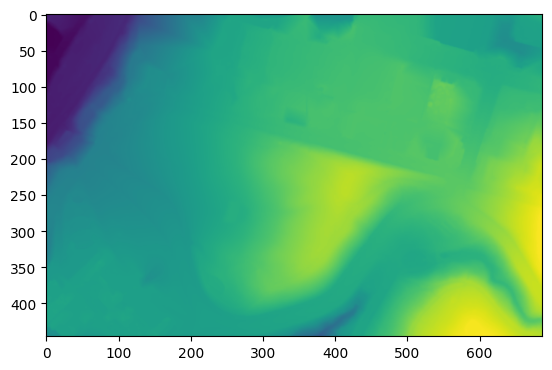

In [11]:
# show elevation data as image
elevation_data = elevation.read(1)
plt.imshow(elevation_data, cmap='viridis')

In [12]:
transformer = Transformer.from_crs("epsg:4326", elevation.crs)
locs = transformer.transform(gps_data.position_lat.values, gps_data.position_long.values)
# get ele

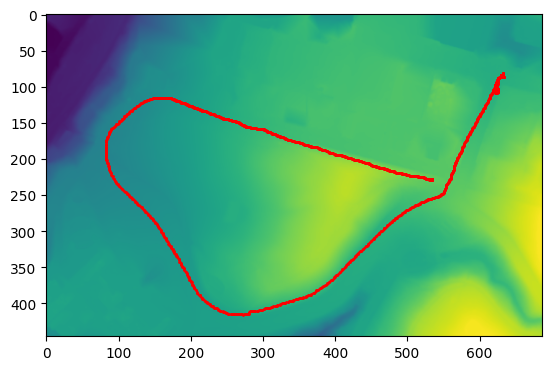

In [14]:
point_list = [elevation.index(x, y) for x, y in zip(locs[0], locs[1])]
points = pd.DataFrame.from_records([{'col': p[1], 'row': p[0]} for p in point_list])
plt.imshow(elevation_data, cmap='viridis')
plt.scatter(x=points.col, y=points.row, c='red', s=1)

In [15]:
elevations = [e[0] for e in elevation.sample(zip(locs[0], locs[1]))]
len(elevations)

2544

In [16]:
gps_data['elevations'] = elevations
px.line(gps_data, y='elevations')

In [26]:
# plot energy, enhanced_speed, and elevation with separate y axes
energy = gps_data.enhanced_speed ** 2 + gps_data.elevations * 9.81

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=energy, name="energy (J/kg)", yaxis="y1")
)

fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=gps_data.enhanced_speed, name="enhanced_speed (m/s)", yaxis="y2")
)

fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=gps_data.elevations, name="elevation (m)", yaxis="y3")
)

fig.update_layout(
    xaxis=dict(domain=[0.15, 1]),
    yaxis=dict(title="energy (J/kg)"),
    yaxis2=dict(title="enhanced_speed (m/s)", 
                anchor="free", overlaying="y", side="left", position=0.05),
    yaxis3=dict(title="elevation (m)",
                anchor="x", overlaying="y", side="right")
)

fig.show()

In [ ]:
px.line(gps_data.heading)

In [ ]:
px.line(accel)

## 3D

In [18]:
stride = 3
elevation_xyz = pd.DataFrame.from_records([
    {'y': i * stride, 'x': j * stride, 'elevation': e} 
    for j, row in enumerate(elevation_data[::stride])
        for i, e in enumerate(row[::stride])
])
elevation_xyz


,y,x,elevation
0,0,0,254.089035
1,3,0,254.092361
2,6,0,254.098526
3,9,0,254.102814
4,12,0,254.112122
...,...,...,...
34116,672,444,306.029633
34117,675,444,305.855835
34118,678,444,305.734558
34119,681,444,305.683075


In [19]:
points.index

RangeIndex(start=0, stop=2544, step=1)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=elevation_xyz.x,
    y=elevation_xyz.y,
    z=elevation_xyz.elevation,
    mode='markers',
    marker=dict(
        size=3,
        color=elevation_xyz.elevation,                
        colorscale='Viridis',   
        opacity=1
    ),
)])

# fig = go.Figure(data=[go.Mesh3d(
#     x=elevation_xyz.x,
#     y=elevation_xyz.y,
#     z=elevation_xyz.elevation,
#     color='gray',
# )])
max_e = elevation_xyz.elevation.max()
fig.update_layout(
    width=1000, 
    height=400,
    margin=dict(l=0, r=0, t=0, b=0),
    scene=dict(
        aspectmode='manual',
        aspectratio=dict(x=3, y=3, z=1),
        zaxis=dict(range=[max_e * 0.75, max_e * 1.1])
    )
)
fig.add_trace(go.Scatter3d(x=points.row, y=points.col, z=elevations,
                           mode='markers', 
                           hovertext=gps_data.index[points.index] / 1000.0,
                           marker=dict(size=5, color=points.index, colorscale='Hot')))
fig.show()

In [85]:
points

,col,row
0,631,85
1,632,85
2,632,86
3,632,86
4,632,86
...,...,...
2539,534,228
2540,533,228
2541,533,228
2542,533,228


# Accel

In [32]:
from scipy import signal, interpolate

In [27]:
calibration_mesgs = messages['three_d_sensor_calibration_mesgs']
calibration_data = { m['sensor_type']: m for m in calibration_mesgs }
accel_cal = calibration_data['accelerometer']
accel_cal

{'timestamp': 2,
 'calibration_factor': 1,
 'calibration_divisor': 2048,
 'level_shift': 32768,
 'offset_cal': [34, -9, -103],
 'orientation_matrix': [0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0],
 'sensor_type': 'accelerometer',
 'accel_cal_factor': 1}

In [28]:
accel_raw_list = []
for group in messages['accelerometer_data_mesgs']:
    base_timestamp = group['timestamp'] * 1000 + group['timestamp_ms']
    for i, offset in enumerate(group['sample_time_offset']):
        entry = {
            'timestamp': base_timestamp + offset,
            'x': group['accel_x'][i],
            'y': group['accel_y'][i],
            'z': group['accel_z'][i],
        }
        accel_raw_list.append(entry)
accel_raw = pd.DataFrame.from_records(accel_raw_list)
accel_raw = accel_raw.set_index('timestamp').sort_index()
accel_raw.index = accel_raw.index 

In [29]:
accel_data = np.array(accel_cal['orientation_matrix']).reshape(3, 3) @ ((accel_raw.to_numpy() \
- accel_cal['level_shift'] - accel_cal['offset_cal']) * \
(accel_cal['calibration_factor'] / accel_cal['calibration_divisor'])).T
accel_data = accel_data.T
accel_data = pd.DataFrame(accel_data, columns=['x', 'y', 'z'], index=accel_raw.index)
fs = 1000 / np.mean(np.diff(accel_data.index))
accel_data

,x,y,z
timestamp,,,
3026,0.117188,-0.121094,-0.986816
3036,0.129883,-0.133301,-0.982910
3046,0.135742,-0.142578,-0.979980
3056,0.148926,-0.138184,-0.985840
3066,0.152832,-0.139648,-0.990234
...,...,...,...
261189,0.068848,0.007324,-0.996094
261199,0.105957,-0.104492,-1.011719
261209,0.087402,-0.287109,-1.009766


In [ ]:
px.line(accel_data.x)

In [ ]:
f, Pxx = signal.welch(accel_data.x.values, float(fs), nperseg=1024)
px.line(pd.DataFrame(index=f, data=dict(PSD=Pxx)))

In [33]:
cs = interpolate.CubicSpline(accel_data.index, accel_data.values)
xs = np.arange((accel_data.index[0] - accel_data.index[0] % 100) + 100, accel_data.index[-1], 10)
interpolated = cs(xs)
accel_uniform = pd.DataFrame(interpolated, columns=['x', 'y', 'z'], index=xs)
accel_uniform

,x,y,z
3100,0.098420,-0.159146,-0.989106
3110,0.092025,-0.159822,-0.985481
3120,0.092528,-0.151096,-0.982078
3130,0.102488,-0.149794,-0.983620
3140,0.107462,-0.158805,-0.988328
...,...,...,...
261180,0.022436,0.048142,-0.983963
261190,0.074376,0.000184,-0.997892
261200,0.106455,-0.121929,-1.012524
261210,0.083818,-0.300474,-1.008318


In [ ]:
decimation = 20
decimated = signal.decimate(accel_uniform.T, decimation)
accel_decimated = pd.DataFrame(decimated.T, columns=['x', 'y', 'z'], index=accel_uniform.index[::decimation])
px.line(accel_decimated.y)

In [36]:
valid_min = max(accel_decimated.index[0], gps_data.index[0])
valid_min = valid_min - valid_min % 100 + 100

valid_max = min(accel_decimated.index[-1], gps_data.index[-1])
valid_max = valid_max - valid_max % 100 - 100

valid = accel_decimated.index[(accel_decimated.index >= valid_min) & (accel_decimated.index <= valid_max)]
a_interp = accel_decimated.loc[valid]
a_interp

,x,y,z
8100,0.097580,-0.169579,-0.974249
8300,0.098439,-0.187923,-0.973722
8500,0.102058,-0.220044,-0.972277
8700,0.107175,-0.235609,-0.968886
8900,0.111167,-0.280119,-0.964247
...,...,...,...
260100,0.093362,0.101474,-0.990779
260300,0.073529,0.061930,-0.988465
260500,0.075259,-0.001328,-0.983777
260700,0.063698,-0.059404,-0.978979


In [37]:
# v_data = pd.DataFrame(gps_data.velocity.to_list(), columns=['x', 'y', 'z'], index=gps_data.index)
v_data = pd.DataFrame.from_records(gps_data.velocity.apply(lambda v: (v[1], v[0], v[2])).to_list(), columns=['x', 'y', 'z'], index=gps_data.index)

In [ ]:
v_cs = interpolate.CubicSpline(v_data.index, v_data.values)
v_interp = pd.DataFrame(v_cs(valid), columns=['x', 'y', 'z'], index=valid)
v_interp

,x,y,z
8100,-0.183908,-0.022790,0.071791
8300,0.188817,-0.184664,0.040434
8500,0.483735,-0.162789,0.039881
8700,0.652413,-0.142594,0.030866
8900,0.683493,-0.079155,0.030505
...,...,...,...
260100,-1.443399,2.975587,-0.089889
260300,-1.264969,2.757886,-0.089999
260500,-1.104531,2.526368,-0.090091
260700,-0.964052,2.296904,-0.099582


In [ ]:
accel_calc = v_cs.derivative()(valid) * (1000 / (valid[1] - valid[0]))
accel_calc = pd.DataFrame(accel_calc, columns=['x', 'y', 'z'], index=valid)

speed_interp = pd.Series(np.linalg.norm(v_interp, axis = 1), index=valid)
d_speed = v_interp.x * accel_calc.x + v_interp.y * accel_calc.y + accel_calc.z * v_interp.z / np.sqrt(v_interp.x ** 2 + v_interp.y ** 2)
px.line(d_speed)

In [138]:
px.line(v_interp)

In [68]:
# remove duplicate points
gps_filtered = gps_data.loc[(gps_data.position_lat.shift(1) != gps_data.position_lat) | (gps_data.position_long.shift(1) != gps_data.position_long)]

interpolate_gps = interpolate.make_splprep([gps_filtered.position_lat.values, gps_filtered.position_long.values], u=gps_filtered.index.values)[0]

,x,y,z
0,-0.04,-0.38,0.08
1,-0.02,-0.23,0.08
2,-0.02,-0.19,0.07
3,-0.02,-0.20,0.05
4,-0.20,0.23,0.04
...,...,...,...
2539,0.44,-0.15,-0.09
2540,0.42,-0.15,-0.09
2541,0.33,-0.12,-0.09
2542,0.31,-0.11,-0.09


In [138]:
(accel_data.index[-1] - accel_data.index[0]) // 10

np.int64(25820)

## Heading

In [70]:
# remove duplicate points
gps_filtered = gps_data.loc[(gps_data.position_lat.shift(1) != gps_data.position_lat) | (gps_data.position_long.shift(1) != gps_data.position_long)]

interpolate_gps = interpolate.make_splprep([gps_filtered.position_lat.values, gps_filtered.position_long.values], u=gps_filtered.index.values)[0]

In [72]:
gps_interp = pd.DataFrame(interpolate_gps(valid).T, columns=['position_lat', 'position_long'], index=valid)

In [158]:
v_filt = lowpass_filter(v_interp.T, 0.5, 1000/(v_interp.index[1] - v_interp.index[0])).T
v_filt = pd.DataFrame(v_filt, columns=['x', 'y', 'z'], index=valid)

In [ ]:
px.line(v_filt)

In [160]:
filt_cs = interpolate.CubicSpline(v_filt.index, v_filt.values)

In [ ]:
v_x = filt_cs(valid)[:, 0]
v_y = filt_cs(valid)[:, 1]
a_x = filt_cs.derivative()(valid)[:, 0]
a_y = filt_cs.derivative()(valid)[:, 1]

curvature = (v_x * a_y - v_y * a_x) / np.pow(v_x **2 + v_y ** 2, 3/2)
curvature = pd.Series(data=curvature, index=valid)
px.line(curvature.iloc[v_x **2 + v_y ** 2 > 2])

In [ ]:
accel_filt = filt_cs.derivative()(valid) * (1000)
accel_filt = pd.DataFrame(accel_filt, columns=['x', 'y', 'z'], index=valid)

speed_filt = pd.Series(np.linalg.norm(v_filt, axis = 1), index=valid)
d_speed = v_filt.x * accel_filt.x + v_filt.y * accel_filt.y +  v_filt.z * accel_filt.z/ np.sqrt(v_filt.x ** 2 + v_filt.y ** 2 + v_filt.z ** 2)
px.line(d_speed + v_filt.z * 9.81)

In [ ]:
px.line(speed_filt)

In [ ]:
px.line(v_filt)

In [ ]:
px.line(-1 * accel_interp)

In [ ]:
heading = gps_data.heading[gps_data.enhanced_speed > 2]
# heading_cs = interpolate.CubicSpline(heading.index, heading.values)
# heading_interp = pd.Series(heading_cs(valid), index=valid)
# px.line(heading_interp)
offsets = np.array([heading.shift(1) - heading, heading.shift(1) - heading - 360, heading.shift(1) - heading + 360])
mins = np.argmin(np.abs(offsets), axis=0)
heading_diffs = pd.Series(offsets[mins, np.arange(len(mins))], index=heading.index).iloc[1:]
# px.line(lowpass_filter(heading_diffs, 2, 10))
px.line(heading_diffs)

In [244]:
heading

95709     221.63
95809     219.48
95909     217.51
96009     216.61
96109     216.55
           ...  
260506    113.61
260606    113.28
260706    112.73
260806    112.34
260906    110.72
Name: heading, Length: 1653, dtype: float64

In [204]:
signal.decimate(diffs[1:], 5)

array([ 2.11718798e+00,  8.19191443e-01,  5.29723926e-01, -2.18300088e-03,
        3.74613641e-02,  2.02335534e-02,  1.23649698e-01,  2.59304302e-01,
       -1.97903938e-01, -7.31038497e-02, -7.93942057e-02, -1.47052379e-01,
        6.89353603e-02, -2.16001338e-01, -2.70801888e-01,  6.13741298e-02,
        1.22615238e-01, -6.71269422e-02,  7.03750556e-02,  2.32717523e-01,
       -1.38731600e-02,  5.31356873e-03, -1.03354959e-01, -2.55091821e-01,
        4.66005505e-03,  9.00088294e-02, -2.63588292e-02, -1.32143400e-01,
        2.43413299e-01,  5.93176548e-01,  2.49012406e-01,  2.23996041e-01,
        2.90376122e-01, -2.42479888e-02, -3.99514210e-03,  2.50414253e-02,
       -4.80812420e-02, -9.38553071e-02, -1.37081161e-01,  6.50751230e-02,
       -2.57162120e-02, -1.33114293e-01,  2.72007713e-02, -1.68546341e-01,
       -2.09853049e-01, -1.49487717e-01, -3.65979300e-01, -5.15108363e-01,
       -5.18266342e-01, -1.81246413e-01, -5.11167195e-01, -9.56978123e-01,
       -8.01868234e-01, -

In [175]:
px.line(heading.shift(1) - heading)

# Gryo, Mag

In [251]:
# TODO: handle multiple calibration messages (for gyro)
def get_sensor_data(calibration, messages, fields):
    raw_list = []
    for group in messages:
        base_timestamp = group['timestamp'] * 1000 + group['timestamp_ms']
        for i, offset in enumerate(group['sample_time_offset']):
            entry = {
                'timestamp': base_timestamp + offset,
            } | {key: group[name][i] for key, name in fields.items()}
            raw_list.append(entry)
    raw = pd.DataFrame.from_records(raw_list)
    raw = raw.set_index('timestamp').sort_index()
    raw.index = raw.index 
    
    data = np.array(calibration['orientation_matrix']).reshape(3, 3) @ ((raw.to_numpy() \
    - calibration['level_shift'] - calibration['offset_cal']) * \
    (calibration['calibration_factor'] / calibration['calibration_divisor'])).T
    data = data.T
    data = pd.DataFrame(data, columns=['x', 'y', 'z'], index=raw.index)
    fs = 1000 / np.mean(np.diff(data.index))
    return raw, data, fs

In [229]:
calibration_mesgs = messages['three_d_sensor_calibration_mesgs']
calibration_data = { m['sensor_type']: m for m in calibration_mesgs }
gyro_cal = calibration_data['gyroscope']
gyro_cal

{'timestamp': 240,
 'calibration_factor': 5,
 'calibration_divisor': 82,
 'level_shift': 32768,
 'offset_cal': [-12, 0, -14],
 'orientation_matrix': [0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0],
 'sensor_type': 'gyroscope',
 'gyro_cal_factor': 5}

In [232]:
gyro_raw, gyro_data, gyro_fs = get_sensor_data(gyro_cal, messages['gyroscope_data_mesgs'], {'x': 'gyro_x', 'y': 'gyro_y', 'z': 'gyro_z'})
gyro_data

,x,y,z
timestamp,,,
3026,-0.426829,-1.402439,0.975610
3036,0.243902,-2.743902,1.219512
3046,-0.792683,-1.890244,1.158537
3056,-1.158537,-1.158537,1.097561
3066,-0.731707,-1.341463,1.036585
...,...,...,...
261189,-2.621951,0.914634,1.707317
261199,-17.560976,-0.060976,4.085366
261209,-31.707317,0.792683,5.609756


In [ ]:
gyro_decimated = -1 * signal.decimate(gyro_data.z, 10).T
gyro_decimated = pd.Series(gyro_decimated, index=gyro_data.index[::10])
px.line(gyro_decimated)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=gyro_decimated.index / 1000.0, y=gyro_decimated, name="gyro_z (rad/s)", yaxis="y1")
)

fig.add_trace(
    go.Scatter(x=heading_diffs.index / 1000.0, y=heading_diffs, name="heading_diffs (deg)", yaxis="y2")
)

fig.update_layout(
    xaxis=dict(title="time (s)"),
    yaxis=dict(title="gyro_z (rad/s)"),
    yaxis2=dict(title="heading_diffs (deg)", overlaying="y", side="right")
)

fig.show()

In [ ]:
px.line()

In [240]:
f_gyro, Pxx_gyro = signal.welch(gyro_data.z.values, float(gyro_fs), nperseg=1024)
px.line(pd.DataFrame(index=f_gyro, data=dict(PSD=Pxx_gyro)))

## Magnetometer

In [252]:
mag_cal = calibration_data['compass']
mag_cal

{'timestamp': 2,
 'calibration_factor': 1,
 'calibration_divisor': 600,
 'level_shift': 32768,
 'offset_cal': [359, -255, -309],
 'orientation_matrix': [0.0,
  0.9230640115968567,
  0.0,
  0.0,
  0.0,
  1.155962462806134,
  -0.9960326543068589,
  0.0,
  0.0],
 'sensor_type': 'compass'}

In [253]:
mag_raw, mag_data, mag_fs = get_sensor_data(mag_cal, messages['magnetometer_data_mesgs'], {'x': 'mag_x', 'y': 'mag_y', 'z': 'mag_z'})
mag_data

,x,y,z
timestamp,,,
3026,0.103075,0.030826,-0.011620
3036,0.104614,0.028899,-0.013280
3046,0.104614,0.030826,-0.011620
3056,0.101537,0.030826,-0.011620
3066,0.101537,0.028899,-0.014940
...,...,...,...
261189,0.472301,-0.015413,0.018261
261199,0.458455,0.003853,0.026561
261209,0.447686,0.011560,0.028221


In [ ]:
mag_decimated = signal.decimate(mag_data.T, 10).T
px.line(mag_decimated)

In [ ]:
mag_heading = 180 - (180 * np.arctan2(mag_decimated[:, 1], mag_decimated[:, 0]))
mag_heading = pd.Series(mag_heading, index=mag_data.index[::10])
px.line(mag_heading)

In [ ]:
px.line(gps_data.heading)